In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from itertools import combinations

In [2]:
def get_prices(file_name):
    
    # read GFD UST aggregate data file and get price (total return index) data
    prices=pd.read_csv(file_name,index_col=0)
    
    # select relevant data ranging from 1926.01-2024.01, subject to chanage
    prices=prices[(prices['date']>='1925-12-01') & (prices['date']<'2024-01-01')][['symbol','date','total_return']]
    
    # Convert 'date' column to datetime type
    prices['date'] = pd.to_datetime(prices['date'])
    
    return prices

In [64]:
def get_return(prices):
    # Sort the dataframe by the 'date' column in ascending order
    prices_sorted = prices.sort_values('date', ascending=True)

    # Select month-end total return index (in prepration for computing returns)
    df_month_end = prices_sorted.groupby(['symbol', pd.Grouper(key='date', freq='ME')])['total_return'].last().reset_index()

    # Calculate monthly returns
    df_month_end['monthly_return'] = df_month_end.groupby('symbol')['total_return'].pct_change()
    monthly_data=df_month_end[['date', 'symbol', 'monthly_return']].copy()
    monthly_data['date'] = df_month_end['date'].dt.strftime('%Y-%m-%d')
    
    return monthly_data

In [98]:
def get_market_cap(file_name,month_end_dates):
    
    # read GFD UST Market Cap data file
    market_cap=pd.read_csv(file_name,index_col=0)
    
    # select relevant years from 1926.01-2024.01
    market_cap=market_cap[(market_cap['date']>='1925-12-01') & (market_cap['date']<'2024-01-01')][['symbol','date','value']]
    market_cap=market_cap[market_cap['date'].isin(month_end_dates)]
    
    # keep the last line of value if there are duplicates for the same ticker
    market_cap = market_cap.drop_duplicates(subset=['date', 'symbol'], keep='last')
    
    # get rid of outliers which had extermely large market cap
    market_cap = market_cap[(market_cap['symbol']!='LMMT1')&(market_cap['symbol']!='GATR2')&(market_cap['symbol']!='RAVN1')
                           &(market_cap['symbol']!='VLKAY1')&(market_cap['symbol']!='UN0A')]
    market_cap = market_cap[~((market_cap['symbol']=='PCRFF') & (market_cap['date']=='1972-04-30'))]
    
    return market_cap

In [66]:
def get_top_monthly_return(major_monthly_data, minor_monthly_data, result, n, dates, return_df):
    
    # to save all the returns for the top n stocks for each month
    all_return = pd.DataFrame()
    
    # based on last month market cap, select this month's return
    for i in range(len(dates)-1):
        
        last_month=dates[i]
        this_month=dates[i+1]
        
        a=result[result['date']==last_month][['symbol','value','weight']]
        b=major_monthly_data[major_monthly_data['date']==this_month][['date','symbol','monthly_return']]
        c=minor_monthly_data[minor_monthly_data['date']==this_month][['date','symbol','monthly_return']]
        
        # the result dataframe (a) contains weights, and merge it with return dataframe (b) and (c)
        major_top_return_df=pd.merge(b, a, on=['symbol'], how='inner')
        minor_top_return_df=pd.merge(c, a, on=['symbol'], how='inner')
        combined_top_return=pd.concat([major_top_return_df, minor_top_return_df])
        all_return=pd.concat([all_return,combined_top_return])
        
        # calculate weighted average returns
        return_df.loc[this_month,'GFD_'+str(n)+'_raw']=(combined_top_return['monthly_return']*combined_top_return['weight']).sum()
    return return_df, all_return

In [105]:
def get_pre_cal_data(return_df):
    
    # get all pre-calculated series data to compare, need to align dates
    GFD_100_pre_calculated=pd.read_csv("GFD Indices USA Top 100 Total Return Index.csv",index_col=0,header=2)
    return_df['GFD_100_pre_calculated']=GFD_100_pre_calculated['Close'].pct_change()[1608:-3].values
    sbbi=pd.read_excel('SBBI - Mar24.xlsx',index_col=0, header=10)
    return_df['sbbi']=sbbi['Ibbotson® SBBI® US Large-Cap Stocks (Total Return)'][:-3].values
    S_P_500=pd.read_csv('GFD Indices US-100 - S&P 500 Total Return Index (USD).csv',index_col=0,header=2)
    return_df['S&P']=S_P_500['Close'].pct_change()[660:-4].values
    CRSP_500=pd.read_csv('CRSP_500.csv',index_col=0)
    return_df['CRSP_500']=CRSP_500['vwretd'].values
    CRSP_50=pd.read_excel('CRSP_50.xlsx',index_col=0)
    return_df['CRSP_50_raw']=CRSP_50.values
    return return_df

In [68]:
def calculate_annualized_return(return_df):
    annulized_return=pd.DataFrame()
    for i in range(0,len(return_df),12):
        the_year=return_df.iloc[i:i+12]
        new_return=pd.DataFrame(((1+the_year).cumprod()-1).iloc[-1]).T
        annulized_return=pd.concat([annulized_return,new_return])
    return annulized_return

In [130]:
def get_output(return_df):
    # write the monthly returns dataframe to an excel
    return_df=get_pre_cal_data(return_df)
    monthly_correlation=pd.DataFrame(return_df.corr())
    print(monthly_correlation)

    # calculate the annualized returns, write the annual returns dataframe to the excel
    annualized_return=calculate_annualized_return(return_df)
    annual_correlation=pd.DataFrame(annualized_return.corr())
    print(annual_correlation)

    # Calculate pairwise mean absolute differences
    pairwise_diff = []

    # Generate combinations of column pairs
    column_combinations = combinations(annualized_return.columns, 2)

    # Iterate over column pairs
    for pair in column_combinations:
        # Calculate absolute difference for each pair of columns
        abs_diff = annualized_return[pair[0]].sub(annualized_return[pair[1]]).abs().mean()
        # Store the pair labels and the mean absolute difference
        pairwise_diff.append((pair, abs_diff))

    annual_diff=pd.DataFrame(pairwise_diff,columns=[['pair','mean absolute difference']])
    
    with pd.ExcelWriter('output.xlsx', mode='w') as writer:
        annualized_return.to_excel(writer, sheet_name='annual returns', index=True)
    with pd.ExcelWriter('output.xlsx', mode='a') as writer:
        annual_correlation.to_excel(writer, sheet_name='annual correlation', index=True)
        annual_diff.to_excel(writer, sheet_name='mean absolute difference', index=True)
        return_df.to_excel(writer, sheet_name='monthly returns', index=True)
        monthly_correlation.to_excel(writer, sheet_name='monthly correlation', index=True)

In [114]:
# top n stock
n=100
    
# load GFD UST total return data series, add data path if necessary
major_monthly_prices=get_prices('Yale_MajorFeedPricing.csv')
minor_monthly_prices=get_prices('Yale_MinorFeedPricing.csv')

# get returns of the data
major_monthly_return=get_return(major_monthly_prices)
minor_monthly_return=get_return(minor_monthly_prices)

month_end_dates=major_monthly_return['date']

# get market cap data
major_market_cap=get_market_cap("MajorExchanges-MarketCap.csv",month_end_dates)
minor_market_cap=get_market_cap("MinorExchanges-MarketCap.csv",month_end_dates)


dates=major_market_cap['date'].unique()

return_df=pd.DataFrame(index=dates[1:])

# get the top n market cap stocks for both major stock exchange
major_result=major_market_cap.groupby('date').apply(lambda x: x.nlargest(n, 'value')).reset_index(drop=True)
# get the top n market cap stocks for both minor stock exchange
minor_result=minor_market_cap.groupby('date').apply(lambda x: x.nlargest(n, 'value')).reset_index(drop=True)
# combine the top n stocks from both exchanges to get top 2n stocks
combined_result=pd.concat([major_result, minor_result])
# get the top n stocks from the combined dataframe
top_df = combined_result.groupby('date').apply(lambda x: x.nlargest(n, 'value')).reset_index(drop=True)

# Group the DataFrame by 'date' and calculate total market cap for each date
total_market_cap_per_date = top_df.groupby('date')['value'].sum()

# Merge the total market cap back into the original DataFrame based on 'date'
result = pd.merge(top_df, total_market_cap_per_date, on='date', suffixes=('', '_total'))

# Calculate weights by dividing individual market cap by total market cap for each date
result['weight'] = result['value'] / result['value_total']

# merge the last month market cap data (result) with this month return data (monthly_returns)
# calculate weighted average returns
return_df, all_return=get_top_monthly_return(major_monthly_return,minor_monthly_return, result,n,dates,return_df)

# get result output
get_output(return_df)

                        GFD_100_raw  GFD_100_pre_calculated      sbbi  \
GFD_100_raw                1.000000                0.958791  0.946014   
GFD_100_pre_calculated     0.958791                1.000000  0.983973   
sbbi                       0.946014                0.983973  1.000000   
S&P                        0.945229                0.983056  0.998961   
CRSP_500                   0.946391                0.978297  0.990170   
CRSP_50_raw                0.958785                0.989357  0.981685   

                             S&P  CRSP_500  CRSP_50_raw  
GFD_100_raw             0.945229  0.946391     0.958785  
GFD_100_pre_calculated  0.983056  0.978297     0.989357  
sbbi                    0.998961  0.990170     0.981685  
S&P                     1.000000  0.989259     0.980662  
CRSP_500                0.989259  1.000000     0.971033  
CRSP_50_raw             0.980662  0.971033     1.000000  
                        GFD_100_raw  GFD_100_pre_calculated      sbbi  \
GFD_100_r

/var/folders/zl/8f_sb4pn5ss4gwzzwy9sqhch0000gn/T/ipykernel_2711/3031527819.py:48: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('output.xlsx', mode='w') as writer:
/var/folders/zl/8f_sb4pn5ss4gwzzwy9sqhch0000gn/T/ipykernel_2711/3031527819.py:54: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('output.xlsx', mode='a') as writer:


In [131]:
# get result output
get_output(return_df)

                        GFD_100_raw  GFD_100_pre_calculated      sbbi  \
GFD_100_raw                1.000000                0.958791  0.946014   
GFD_100_pre_calculated     0.958791                1.000000  0.983973   
sbbi                       0.946014                0.983973  1.000000   
S&P                        0.945229                0.983056  0.998961   
CRSP_500                   0.946391                0.978297  0.990170   
CRSP_50_raw                0.958785                0.989357  0.981685   

                             S&P  CRSP_500  CRSP_50_raw  
GFD_100_raw             0.945229  0.946391     0.958785  
GFD_100_pre_calculated  0.983056  0.978297     0.989357  
sbbi                    0.998961  0.990170     0.981685  
S&P                     1.000000  0.989259     0.980662  
CRSP_500                0.989259  1.000000     0.971033  
CRSP_50_raw             0.980662  0.971033     1.000000  
                        GFD_100_raw  GFD_100_pre_calculated      sbbi  \
GFD_100_r

/var/folders/zl/8f_sb4pn5ss4gwzzwy9sqhch0000gn/T/ipykernel_2711/3027575548.py:27: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('output.xlsx', mode='w') as writer:
/var/folders/zl/8f_sb4pn5ss4gwzzwy9sqhch0000gn/T/ipykernel_2711/3027575548.py:29: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('output.xlsx', mode='a') as writer:


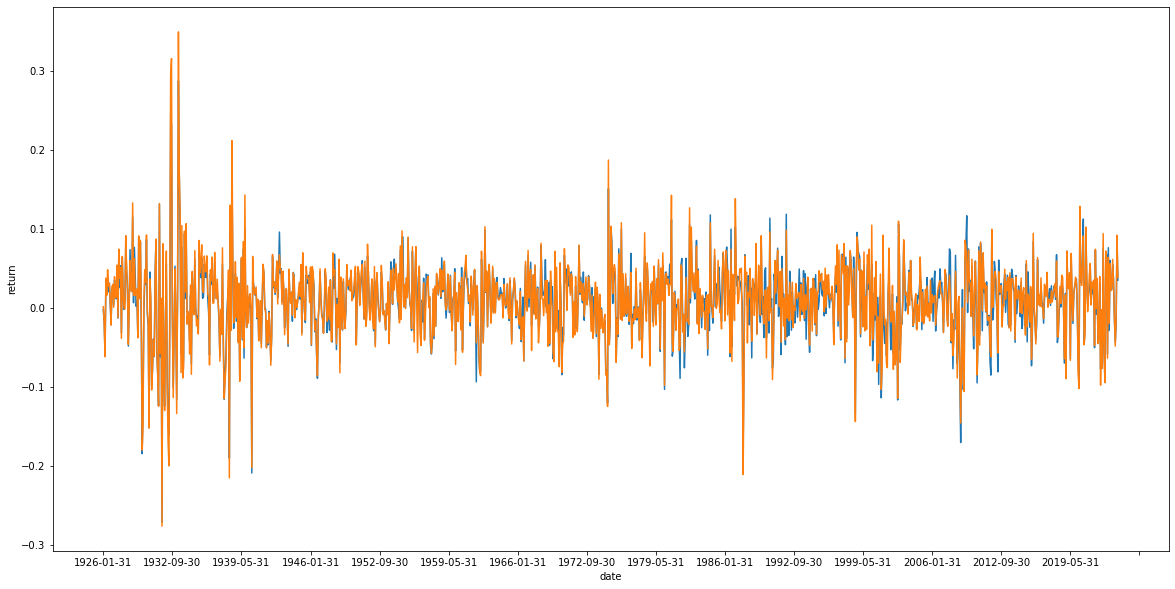

In [115]:
from matplotlib.ticker import MaxNLocator
# show the differences between the returns calculated from raw data and pre-calculated data
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(return_df[['GFD_100_raw','GFD_100_pre_calculated']])

ax.set_xlabel('date')
ax.set_ylabel('return')

# Adding a legend
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.show()

Text(0.5, 1.0, 'Histogram of difference of Raw and Pre-calc GFD 100')

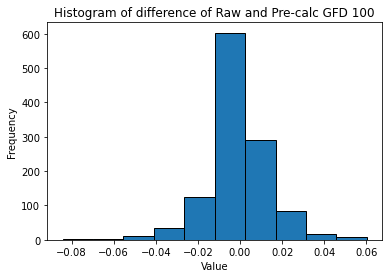

In [132]:
data=(return_df['GFD_100_raw']-return_df['GFD_100_pre_calculated'])
plt.hist(data, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of difference of Raw and Pre-calc GFD 100')

In [113]:
(return_df['GFD_100_raw']-return_df['GFD_100_pre_calculated']).sort_values()

1932-08-31   -0.084307
1933-04-30   -0.061991
2013-05-31   -0.059222
1932-07-31   -0.050520
2000-03-31   -0.050063
                ...   
1999-09-30    0.047944
1956-05-31    0.052900
2007-10-31    0.054818
1986-04-30    0.057728
2009-05-31    0.060313
Length: 1176, dtype: float64